In [1]:
#Import Required Libraries
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report 
import seaborn as sns
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.svm import SVC

In [ ]:
def plot_learning_curve(model, X, y, X_train=None, X_val=None, y_train=None, y_val=None):

  if X_train is None: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)
  train_errors, val_errors = [], []
  train_size = np.linspace(30, len(X_train), 13).astype(int)
  for m in train_size:
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)

    train_errors.append(f1_score(y_train[:m], y_train_predict, average='macro'))
    val_errors.append(f1_score(y_val, y_val_predict, average= 'macro'))
  plt.grid()
  plt.plot(train_size, train_errors, 'r', label= 'Training Error')
  plt.plot(train_size, val_errors, 'b', label = 'Validation Error')
  plt.ylabel('F1 Macro Score')
  plt.xlabel('Training Example Size')
  plt.legend(loc='best')

In [ ]:
def plot_learning_curve_hyper(df, x_axis_label, y_axis_label, title, ax=None, ylim=None):
  x = []
  for ele in df.params:
    for k, v in ele.items():
      x.append(str(v))
  if ax is None:
    _, ax = plt.subplots(figsize=(14, 10))

  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.grid()
  ax.fill_between(
    x,
    (df['mean_train_score'] - df['std_train_score']).values,
    (df['mean_train_score'] + df['std_train_score']).values,
    alpha=0.1,
    color="r",
    )
  ax.fill_between(
    x,
    (df['mean_test_score'] - df['std_test_score']).values,
    (df['mean_test_score'] + df['std_test_score']).values,
    alpha=0.1,
    color="g",
    )
  ax.plot(x, df['mean_train_score'], "x-", color = 'r', label = 'Training Score')
  ax.plot(x, df['mean_test_score'], "x-", color = 'g', label = 'Cross-validation Score')
  ax.legend(loc="best")

In [ ]:
def up_sampling(X_train, y_train):
  #Concatonate our our training data back together
  X = pd.concat([X_train, y_train], axis=1)
  #Seprate Minority and Majority Class
  opened_account = X[X['Personal Loan'] == 1]
  not_opened_account = X[X['Personal Loan'] == 0]
  #Upsample the Minority Class
  opened_account_upsampled = resample(opened_account,
                                      replace = True, #sample with replacement
                                      n_samples= len(not_opened_account), #match the number of not opened account
                                      random_state = 27)
  upsampled = pd.concat([opened_account_upsampled, not_opened_account])
  return upsampled

In [ ]:
#Mount to Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
% cd /content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT


In [ ]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')

In [ ]:
X = df.drop(['Personal Loan', 'ID', 'ZIP Code'], axis=1)
y = df['Personal Loan']

In [ ]:
y.value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

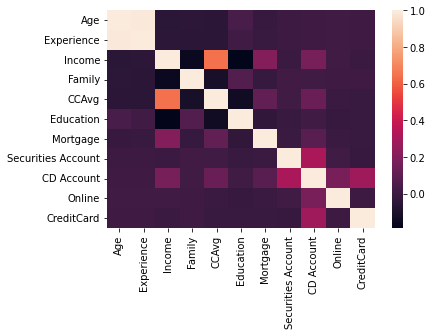

In [ ]:
# Checking Corelation heatmap
import seaborn as sns
corr = X.corr()
sns.heatmap(corr)

In [ ]:
#Dropping Age column for colinearity
X.drop('Age', axis=1, inplace=True)

In [ ]:
#Split the dataset to train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    random_state=27,stratify=y)

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

0    3390
1     360
Name: Personal Loan, dtype: int64
0    1130
1     120
Name: Personal Loan, dtype: int64


In [ ]:
#Group Columns based on type
normal_col = ['Experience']
skewd_col = ['Income', 'CCAvg', 'Mortgage']
cat_col = ['Family', 'Education']

In [ ]:
#Make Copy of X_train and X_test
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])
cat_pipeline = Pipeline(steps=[('one_hot', OneHotEncoder())])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col),
        ('Categorical_onhot', cat_pipeline, cat_col)],remainder ='passthrough')

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)

In [ ]:
# Try Quick and Dirty SVM

clf_svm = SVC(random_state = 0)

clf_svm.fit(X_train, y_train)

y_pred = clf_svm.predict(X_test)      

In [ ]:
print(f'Classification report on test set using naive SVM:\n\n {classification_report(y_pred, y_test)}')

Classification report on test set using naive SVM:

               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1238
           1       0.07      0.67      0.12        12

    accuracy                           0.91      1250
   macro avg       0.53      0.79      0.54      1250
weighted avg       0.99      0.91      0.94      1250



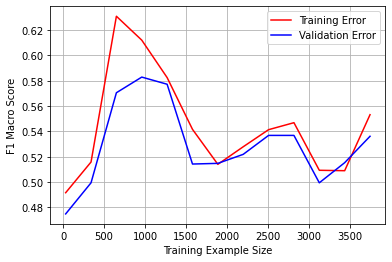

In [ ]:
plot_learning_curve(clf_svm, X, y)

In [ ]:
y_predTrain = clf_svm.predict(X_train)
print(f'Classification report on test set using naive SVM:\n\n {classification_report(y_predTrain, y_train)}')

Classification report on test set using naive SVM:

               precision    recall  f1-score   support

           0       1.00      0.91      0.95      3708
           1       0.09      0.74      0.15        42

    accuracy                           0.91      3750
   macro avg       0.54      0.82      0.55      3750
weighted avg       0.99      0.91      0.94      3750



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf = SVC(random_state = 0)
#Check for optimal Kernel

param_grid = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               }]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
df_kernel = pd.DataFrame(grid_search.cv_results_)
grid_search.best_params_

{'kernel': 'rbf'}

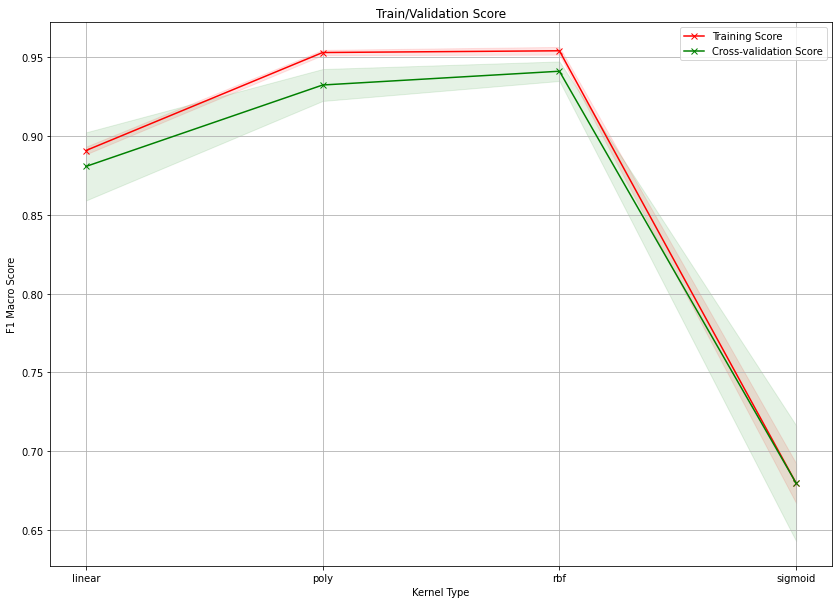

In [ ]:
plot_learning_curve_hyper(df_kernel, 'Kernel Type', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0)
#Check for optimal C

param_grid = [{'C': np.arange(3, 6, 0.2).round(2)}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'C': array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4,
       5.6, 5.8])}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
df_c = pd.DataFrame(grid_search.cv_results_)

{'C': 5.4}


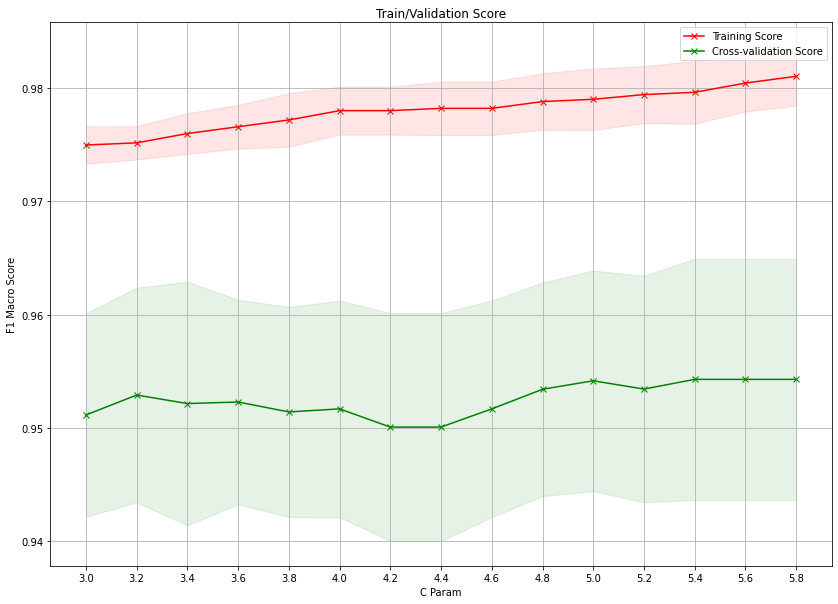

In [ ]:
plot_learning_curve_hyper(df_c, 'C Param', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0)
#Check for optimal gama

param_grid = [{'gamma': ['scale', 'auto']}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'gamma': ['scale', 'auto']}], return_train_score=True,
             scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
df_gamma = pd.DataFrame(grid_search.cv_results_)

{'gamma': 'scale'}


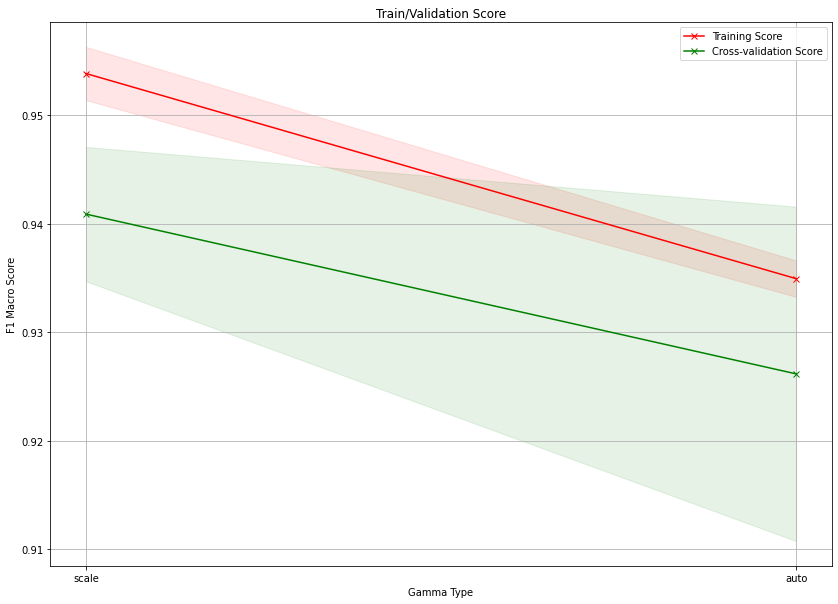

In [ ]:
plot_learning_curve_hyper(df_gamma, 'Gamma Type', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0)


param_grid = [{'class_weight': ['balanced', None]}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', None]}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
df_class_weight = pd.DataFrame(grid_search.cv_results_)

{'class_weight': None}


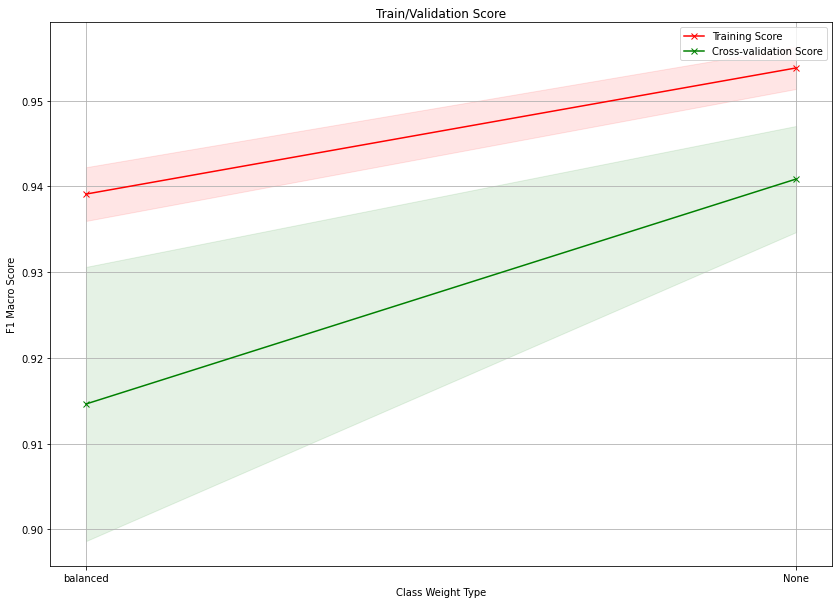

In [ ]:
plot_learning_curve_hyper(df_class_weight, 'Class Weight Type', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0, C = 5.400000000000002)


param_grid = [{'class_weight': ['balanced', None],
               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'degree': [i for i in range(1,4)]}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=5, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=5, estimator=SVC(C=5.400000000000002, random_state=0),
             n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', None],
                          'degree': [1, 2, 3],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
final_model = grid_search.best_estimator_

{'class_weight': None, 'degree': 1, 'kernel': 'rbf'}


In [ ]:
from sklearn.metrics import f1_score, classification_report

y_pred_final = final_model.predict(X_test_stand)
print(f"F1 Weighted Score on Test Set: {f1_score(y_test, y_pred_final, average='weighted'):.2f}")
print(f'\nClassification report on test set:\n\n {classification_report(y_test, y_pred_final, zero_division=1)}')
print(f'\nClassification report on training set:\n\n {classification_report(y_train, final_model.predict(X_train_stand), zero_division=1)}')

F1 Weighted Score on Test Set: 0.98

Classification report on test set:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1130
           1       0.91      0.89      0.90       120

    accuracy                           0.98      1250
   macro avg       0.95      0.94      0.95      1250
weighted avg       0.98      0.98      0.98      1250


Classification report on training set:

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3390
           1       0.99      0.93      0.96       360

    accuracy                           0.99      3750
   macro avg       0.99      0.96      0.98      3750
weighted avg       0.99      0.99      0.99      3750



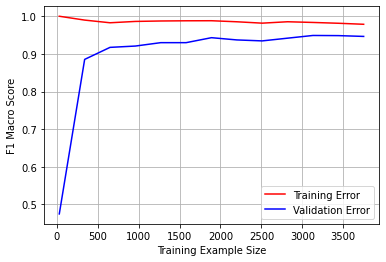

In [ ]:
plot_learning_curve(final_model, X, y, X_train = X_train_stand, X_val = X_test_stand,
                    y_train= y_train, y_val = y_test)